In [1]:
import pandas as pd
import numpy as np
from matplotlib import  pyplot as plt


data = pd.read_csv("../data/interim/003-raw-clean-data.csv",index_col=0)

In [26]:
from sklearn.ensemble import (RandomForestRegressor,
                              AdaBoostRegressor,
                              GradientBoostingRegressor,
                              ExtraTreesRegressor
                              )
from sklearn import tree
from sklearn import metrics
from sklearn import model_selection

from sklearn.linear_model import SGDRegressor
from sklearn.svm import SVR,LinearSVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor

In [17]:
from time import time
def tuner(clf,x,y,params,cv_fold=5,n_iter = 10):
    cv = model_selection.RandomizedSearchCV(estimator=clf,param_distributions=params,n_iter=n_iter,scoring={"r2" : metrics.make_scorer(metrics.r2_score),"mse" : "neg_mean_squared_error"},cv=cv_fold,verbose=2,return_train_score=True,refit="r2")
    cv.fit(x,y)
    return cv

def benchmark(clf,X_train,y_train,X_test,y_test,params,feature_names=None,**kwargs):
    print('_' * 80)
    print("Training: ")
    print(str(clf).split('(')[0])
    t0 = time()

    cv_res = tuner(clf,X_train,y_train,params=params,n_iter=kwargs.get('n_iter',10),cv_fold=kwargs.get('cv_fold',5))
    train_time = time() - t0
    print("train time: %0.3fs" % train_time)

    t0 = time()
    y_pred = cv_res.best_estimator_.predict(X_test)
    r2 = metrics.r2_score(y_test, y_pred)
    mae = metrics.mean_absolute_error(y_test, y_pred)
    mse = metrics.mean_squared_error(y_test, y_pred)
    print("r2:",r2)
    print("Mean Absolute Error :",mae)
    print("Mean Sq Error :",mse)    
    test_time = time() - t0
    print("test time:  %0.3fs" % test_time)

    if hasattr(clf, 'coef_'):
        print("dimensionality: %d" % clf.coef_.shape[1])
        print("density: %f" % density(clf.coef_))

        if feature_names is not None:
            importance = cv_res.best_estimator_.coef_
            x = np.argsort(importance)[-20:]
            plt.bar(range(0,len(x)),importance[x])
            plt.xticks(range(0,len(x)),tuple(feature_names[x]),rotation='vertical')
            plt.show()
            print("top 10 keywords per class:")            
            print(" ".join(feature_names[x]))
        print()
    elif hasattr(clf,'feature_importances_'):
        if feature_names is not None:
            importance = cv_res.best_estimator_.feature_importances_
            x = np.argsort(importance)[-20:]
            plt.bar(range(0,len(x)),importance[x])
            plt.xticks(range(0,len(x)),tuple(feature_names[x]),rotation='vertical')
            plt.show()
            print("top 10 keywords per class:")            
            print(" ".join(feature_names[x]))
        print()
    
    print()
    return cv_res.best_estimator_,pd.DataFrame(cv_res.cv_results_),mse,mae,r2, train_time, test_time


In [4]:
pred_cont = ['location','measurement_depth_cm', 'measurement_height_cm',
       'measurement_width_cm', 'material', 'day', 'month', 'week', 'year',
       'surface', 'is_artist_dead', 'aspect_ratio', 'years_sold']
dummy = ['location','material']

X = pd.get_dummies(data[pred_cont],columns=dummy)
lbl = data["hammer_price"]
train,test,y_train,y_test = model_selection.train_test_split(X,lbl,train_size=0.7,test_size=0.3)

In [31]:
from mlxtend.regressor import StackingCVRegressor
rf = RandomForestRegressor(n_jobs=-1,verbose=1)
stack = StackingCVRegressor(
    regressors=(        
        KNeighborsRegressor(n_neighbors=3),
        KNeighborsRegressor(n_neighbors=7),
        KNeighborsRegressor(n_neighbors=5),
        SGDRegressor(loss='epsilon_insensitive',alpha=0.1),
        SGDRegressor(loss='epsilon_insensitive',alpha=0.0001 ),
        SGDRegressor(loss='epsilon_insensitive',alpha = 100)
    ),meta_regressor=rf,use_features_in_secondary=False,store_train_meta_features=True)

param_grid={            
        'meta-randomforestregressor__n_estimators': [10,50,100,500],
        'meta-randomforestregressor__max_features' : [3,5,0.3,0.5,0.7]
    }

res = benchmark(stack,train.values,y_train.values,test.values,y_test.values,param_grid,np.array(train.columns),n_iter=2,cv_fold=3)


/usr/local/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:84: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


________________________________________________________________________________
Training: 
StackingCVRegressor
Fitting 3 folds for each of 2 candidates, totalling 6 fits
[CV] meta-randomforestregressor__n_estimators=500, meta-randomforestregressor__max_features=0.7 


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   12.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   30.3s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   34.9s finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.6s finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.6s finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    1.0s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:  

[CV]  meta-randomforestregressor__n_estimators=500, meta-randomforestregressor__max_features=0.7, total=  54.4s
[CV] meta-randomforestregressor__n_estimators=500, meta-randomforestregressor__max_features=0.7 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.2min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   13.9s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   35.2s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   40.2s finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.8s finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.7s finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 434 task

[CV]  meta-randomforestregressor__n_estimators=500, meta-randomforestregressor__max_features=0.7, total= 1.0min
[CV] meta-randomforestregressor__n_estimators=500, meta-randomforestregressor__max_features=0.7 


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   13.6s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   34.5s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   39.5s finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.7s finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.9s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:  

[CV]  meta-randomforestregressor__n_estimators=500, meta-randomforestregressor__max_features=0.7, total= 1.0min
[CV] meta-randomforestregressor__n_estimators=50, meta-randomforestregressor__max_features=0.5 


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    2.8s finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.1s finished


[CV]  meta-randomforestregressor__n_estimators=50, meta-randomforestregressor__max_features=0.5, total=  21.3s
[CV] meta-randomforestregressor__n_estimators=50, meta-randomforestregressor__max_features=0.5 


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    2.7s finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.1s finished


[CV]  meta-randomforestregressor__n_estimators=50, meta-randomforestregressor__max_features=0.5, total=  21.5s
[CV] meta-randomforestregressor__n_estimators=50, meta-randomforestregressor__max_features=0.5 


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    3.1s finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  5.6min finished


[CV]  meta-randomforestregressor__n_estimators=50, meta-randomforestregressor__max_features=0.5, total=  22.4s


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    4.3s finished


train time: 357.707s
r2: 0.104863110407
Mean Absolute Error : 126425.996559
Mean Sq Error : 566165515779.0
test time:  5.500s



[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.1s finished


In [8]:
gb_grid_params = {
    'learning_rate': [0.1, 0.05, 0.02, 0.01],
    'max_depth': [4, 6, 8],
    'min_samples_leaf': [20, 50,100,150],
    'max_features': [1.0, 0.3, 0.1],
    'n_estimators':list(range(20,81,10))
}
clf = KNeighborsRegressor()
res = benchmark(clf,train,y_train,test,y_test,gb_grid_params,np.array(train.columns),n_iter=30)


________________________________________________________________________________
Training: 
GradientBoostingRegressor
Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV] n_estimators=30, min_samples_leaf=150, max_features=0.3, max_depth=4, learning_rate=0.01 
[CV]  n_estimators=30, min_samples_leaf=150, max_features=0.3, max_depth=4, learning_rate=0.01, total=   1.5s
[CV] n_estimators=30, min_samples_leaf=150, max_features=0.3, max_depth=4, learning_rate=0.01 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s remaining:    0.0s


[CV]  n_estimators=30, min_samples_leaf=150, max_features=0.3, max_depth=4, learning_rate=0.01, total=   1.5s
[CV] n_estimators=30, min_samples_leaf=150, max_features=0.3, max_depth=4, learning_rate=0.01 
[CV]  n_estimators=30, min_samples_leaf=150, max_features=0.3, max_depth=4, learning_rate=0.01, total=   1.5s
[CV] n_estimators=30, min_samples_leaf=150, max_features=0.3, max_depth=4, learning_rate=0.01 
[CV]  n_estimators=30, min_samples_leaf=150, max_features=0.3, max_depth=4, learning_rate=0.01, total=   1.4s
[CV] n_estimators=30, min_samples_leaf=150, max_features=0.3, max_depth=4, learning_rate=0.01 
[CV]  n_estimators=30, min_samples_leaf=150, max_features=0.3, max_depth=4, learning_rate=0.01, total=   1.4s
[CV] n_estimators=70, min_samples_leaf=20, max_features=0.3, max_depth=6, learning_rate=0.02 
[CV]  n_estimators=70, min_samples_leaf=20, max_features=0.3, max_depth=6, learning_rate=0.02, total=   6.7s
[CV] n_estimators=70, min_samples_leaf=20, max_features=0.3, max_depth=6

[CV]  n_estimators=30, min_samples_leaf=100, max_features=0.1, max_depth=6, learning_rate=0.05, total=   1.2s
[CV] n_estimators=30, min_samples_leaf=100, max_features=0.1, max_depth=6, learning_rate=0.05 
[CV]  n_estimators=30, min_samples_leaf=100, max_features=0.1, max_depth=6, learning_rate=0.05, total=   1.2s
[CV] n_estimators=30, min_samples_leaf=100, max_features=0.1, max_depth=6, learning_rate=0.05 
[CV]  n_estimators=30, min_samples_leaf=100, max_features=0.1, max_depth=6, learning_rate=0.05, total=   1.1s
[CV] n_estimators=60, min_samples_leaf=50, max_features=1.0, max_depth=6, learning_rate=0.02 
[CV]  n_estimators=60, min_samples_leaf=50, max_features=1.0, max_depth=6, learning_rate=0.02, total=  16.4s
[CV] n_estimators=60, min_samples_leaf=50, max_features=1.0, max_depth=6, learning_rate=0.02 
[CV]  n_estimators=60, min_samples_leaf=50, max_features=1.0, max_depth=6, learning_rate=0.02, total=  16.2s
[CV] n_estimators=60, min_samples_leaf=50, max_features=1.0, max_depth=6, 

[CV]  n_estimators=20, min_samples_leaf=20, max_features=1.0, max_depth=8, learning_rate=0.02, total=  11.4s
[CV] n_estimators=20, min_samples_leaf=20, max_features=1.0, max_depth=8, learning_rate=0.02 
[CV]  n_estimators=20, min_samples_leaf=20, max_features=1.0, max_depth=8, learning_rate=0.02, total=  11.0s
[CV] n_estimators=20, min_samples_leaf=20, max_features=1.0, max_depth=6, learning_rate=0.02 
[CV]  n_estimators=20, min_samples_leaf=20, max_features=1.0, max_depth=6, learning_rate=0.02, total=   6.0s
[CV] n_estimators=20, min_samples_leaf=20, max_features=1.0, max_depth=6, learning_rate=0.02 
[CV]  n_estimators=20, min_samples_leaf=20, max_features=1.0, max_depth=6, learning_rate=0.02, total=   5.8s
[CV] n_estimators=20, min_samples_leaf=20, max_features=1.0, max_depth=6, learning_rate=0.02 
[CV]  n_estimators=20, min_samples_leaf=20, max_features=1.0, max_depth=6, learning_rate=0.02, total=   6.2s
[CV] n_estimators=20, min_samples_leaf=20, max_features=1.0, max_depth=6, learn

[CV]  n_estimators=30, min_samples_leaf=150, max_features=1.0, max_depth=8, learning_rate=0.1, total=  12.3s
[CV] n_estimators=50, min_samples_leaf=100, max_features=0.1, max_depth=6, learning_rate=0.05 
[CV]  n_estimators=50, min_samples_leaf=100, max_features=0.1, max_depth=6, learning_rate=0.05, total=   2.0s
[CV] n_estimators=50, min_samples_leaf=100, max_features=0.1, max_depth=6, learning_rate=0.05 
[CV]  n_estimators=50, min_samples_leaf=100, max_features=0.1, max_depth=6, learning_rate=0.05, total=   2.0s
[CV] n_estimators=50, min_samples_leaf=100, max_features=0.1, max_depth=6, learning_rate=0.05 
[CV]  n_estimators=50, min_samples_leaf=100, max_features=0.1, max_depth=6, learning_rate=0.05, total=   2.0s
[CV] n_estimators=50, min_samples_leaf=100, max_features=0.1, max_depth=6, learning_rate=0.05 
[CV]  n_estimators=50, min_samples_leaf=100, max_features=0.1, max_depth=6, learning_rate=0.05, total=   2.2s
[CV] n_estimators=50, min_samples_leaf=100, max_features=0.1, max_depth

[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed: 20.3min finished


train time: 1229.458s
r2: 0.26787986903
Mean Absolute Error : 115242.19914
Mean Sq Error : 463058976099.0
test time:  0.080s



In [15]:
res[1].sort_values('mean_test_r2',ascending=False).loc[6,'params']


{'learning_rate': 0.1,
 'max_depth': 8,
 'max_features': 0.3,
 'min_samples_leaf': 20,
 'n_estimators': 50}

In [15]:
## Let's do something for RandomForestRegressor
# We will not use OneHotEncoding for categorical 

data.loc[:,"material"]= pd.Categorical(data.material.factorize()[0])
data.loc[:,"location"]= pd.Categorical(data.location.factorize()[0])
data.loc[:,"category"]= pd.Categorical(data.category.factorize()[0])
data.loc[:,"artist_nationality"]= pd.Categorical(data.artist_nationality.factorize()[0])
data.loc[:,"artist_name"]= pd.Categorical(data.artist_name.factorize()[0])

In [17]:
pred = list(data.columns)
pred.remove("hammer_price")

lbl = data["hammer_price"]
data = data[pred]

In [53]:
train,test,y_train,y_test = model_selection.train_test_split(data,lbl,train_size=0.7,test_size=0.3)

In [34]:
data = pd.read_csv("../data/processed/data.csv",index_col=0,encoding='latin-1')
lbl = data["hammer_price"]

In [35]:
train,test,y_train,y_test = model_selection.train_test_split(data,lbl,train_size=0.7,test_size=0.3)

In [55]:
train.materials.factorize()

(array([0, 1, 2, ..., 0, 0, 1]),
 Index(['paper', 'sculpture', 'prints', 'canvas', 'other'], dtype='object'))

In [ ]:
cv_res = tuner(RandomForestRegressor(criterion='mse',n_jobs=4,oob_score=True,verbose=1),train,y_train,
               {'n_estimators':[100,500,1000,5000],'max_features':[3,5,0.3,0.5,0.7],'max_depth':[None,10,20]})

In [55]:
res = pd.DataFrame(cv_res.cv_results_)

In [57]:
res.sort_values('mean_test_r2',ascending=False)

,mean_fit_time,mean_score_time,mean_test_mse,mean_test_r2,mean_train_mse,mean_train_r2,param_max_depth,param_max_features,param_n_estimators,params,...,split4_test_mse,split4_test_r2,split4_train_mse,split4_train_r2,std_fit_time,std_score_time,std_test_mse,std_test_r2,std_train_mse,std_train_r2
9,67.092548,2.929700,-1.569558e+11,0.517289,-2.213067e+10,0.933347,None,0.5,1000,"{'n_estimators': 1000, 'max_features': 0.5, 'm...",...,-1.140404e+11,0.638708,-2.319066e+10,0.931251,0.362178,0.070456,7.179151e+10,0.069457,2.182343e+09,0.002230
0,22.430072,1.468859,-1.591920e+11,0.514051,-2.255908e+10,0.932218,None,5,500,"{'n_estimators': 500, 'max_features': 5, 'max_...",...,-1.164099e+11,0.631202,-2.389968e+10,0.929149,0.372589,0.012181,7.637502e+10,0.066576,2.646701e+09,0.002599
2,19.720743,1.083194,-1.593090e+11,0.513305,-2.288892e+10,0.931060,20,5,500,"{'n_estimators': 500, 'max_features': 5, 'max_...",...,-1.158958e+11,0.632830,-2.425767e+10,0.928087,0.283821,0.003671,7.624939e+10,0.067822,2.272612e+09,0.002650
5,27.540120,1.093851,-1.588524e+11,0.513162,-2.303963e+10,0.930639,20,0.5,500,"{'n_estimators': 500, 'max_features': 0.5, 'ma...",...,-1.139951e+11,0.638852,-2.425127e+10,0.928106,0.173322,0.006119,7.449349e+10,0.070527,2.352096e+09,0.002231
7,35.166905,1.044233,-1.594466e+11,0.509320,-2.311212e+10,0.930325,20,0.7,500,"{'n_estimators': 500, 'max_features': 0.7, 'ma...",...,-1.139797e+11,0.638901,-2.404704e+10,0.928712,0.146262,0.049709,7.291085e+10,0.072213,2.139182e+09,0.002923
3,35.970424,2.951255,-1.637246e+11,0.503215,-2.269572e+10,0.931688,None,3,1000,"{'n_estimators': 1000, 'max_features': 3, 'max...",...,-1.209990e+11,0.616663,-2.378535e+10,0.929488,0.342292,0.085187,8.124688e+10,0.065259,2.332496e+09,0.002145
4,28.786625,0.868379,-1.861056e+11,0.423767,-8.596770e+10,0.739743,10,0.5,1000,"{'n_estimators': 1000, 'max_features': 0.5, 'm...",...,-1.365282e+11,0.567465,-8.695660e+10,0.742214,0.275454,0.004281,8.155763e+10,0.085170,5.464706e+09,0.018749
8,10.404280,0.458256,-1.902067e+11,0.411089,-9.690743e+10,0.706999,10,5,500,"{'n_estimators': 500, 'max_features': 5, 'max_...",...,-1.416323e+11,0.551295,-9.846992e+10,0.708083,0.152121,0.004775,8.366885e+10,0.085325,6.757334e+09,0.017200
1,88.611972,3.519318,-1.939328e+11,0.401574,-1.030388e+11,0.688394,10,0.3,5000,"{'n_estimators': 5000, 'max_features': 0.3, 'm...",...,-1.447108e+11,0.541542,-1.052149e+11,0.688087,1.870648,0.022443,8.720376e+10,0.084229,7.125959e+09,0.019167
6,1.538806,0.245628,-2.013489e+11,0.377086,-1.137008e+11,0.656473,10,3,100,"{'n_estimators': 100, 'max_features': 3, 'max_...",...,-1.542009e+11,0.511476,-1.148783e+11,0.659440,0.051946,0.004342,8.825419e+10,0.084851,8.672395e+09,0.018590


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    2.5s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    3.1s finished


r2: 0.423140729039
Mean Absolute Error : 85340.5745092
Mean Sq Error : 407242682129.0


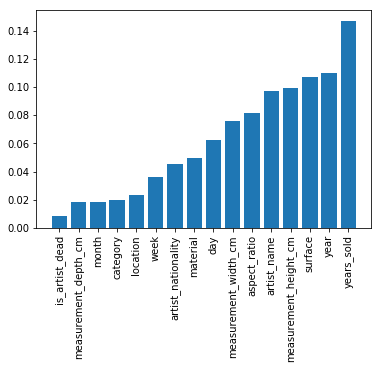

In [60]:
y_pred = cv_res.best_estimator_.predict(test)
print("r2:",metrics.r2_score(y_test, y_pred))
print("Mean Absolute Error :",metrics.mean_absolute_error(y_test, y_pred))
print("Mean Sq Error :",metrics.mean_squared_error(y_test, y_pred))
importance = cv_res.best_estimator_.feature_importances_
x = np.argsort(importance)[-20:]
plt.bar(range(0,len(x)),importance[x])
plt.xticks(range(0,len(x)),tuple(data.columns.values[x]),rotation='vertical')
plt.show()

In [61]:
params = {
    'n_estimators':[100,50,500,1000],
    'learning_rate':[0.1,0.2,0.3,0.5,0.7],
    'loss':['linear','square','exponential'],
    'base_estimator__splitter' : ['best','random'],
    'base_estimator__max_features' : [3,5,'sqrt',0.3],
}
cv_res_adaboost = tuner(AdaBoostRegressor(base_estimator=tree.DecisionTreeRegressor(max_features=3)),train,y_train,params=params)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] n_estimators=50, loss=exponential, learning_rate=0.7, base_estimator__splitter=best, base_estimator__max_features=sqrt 
[CV]  n_estimators=50, loss=exponential, learning_rate=0.7, base_estimator__splitter=best, base_estimator__max_features=sqrt, total=   5.2s
[CV] n_estimators=50, loss=exponential, learning_rate=0.7, base_estimator__splitter=best, base_estimator__max_features=sqrt 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.6s remaining:    0.0s


[CV]  n_estimators=50, loss=exponential, learning_rate=0.7, base_estimator__splitter=best, base_estimator__max_features=sqrt, total=   8.6s
[CV] n_estimators=50, loss=exponential, learning_rate=0.7, base_estimator__splitter=best, base_estimator__max_features=sqrt 
[CV]  n_estimators=50, loss=exponential, learning_rate=0.7, base_estimator__splitter=best, base_estimator__max_features=sqrt, total=   5.0s
[CV] n_estimators=50, loss=exponential, learning_rate=0.7, base_estimator__splitter=best, base_estimator__max_features=sqrt 
[CV]  n_estimators=50, loss=exponential, learning_rate=0.7, base_estimator__splitter=best, base_estimator__max_features=sqrt, total=   5.7s
[CV] n_estimators=50, loss=exponential, learning_rate=0.7, base_estimator__splitter=best, base_estimator__max_features=sqrt 
[CV]  n_estimators=50, loss=exponential, learning_rate=0.7, base_estimator__splitter=best, base_estimator__max_features=sqrt, total=   7.5s
[CV] n_estimators=100, loss=square, learning_rate=0.3, base_estim

[CV]  n_estimators=50, loss=square, learning_rate=0.2, base_estimator__splitter=best, base_estimator__max_features=0.3, total=   8.9s
[CV] n_estimators=50, loss=square, learning_rate=0.2, base_estimator__splitter=best, base_estimator__max_features=0.3 
[CV]  n_estimators=50, loss=square, learning_rate=0.2, base_estimator__splitter=best, base_estimator__max_features=0.3, total=   9.1s
[CV] n_estimators=100, loss=linear, learning_rate=0.1, base_estimator__splitter=random, base_estimator__max_features=3 
[CV]  n_estimators=100, loss=linear, learning_rate=0.1, base_estimator__splitter=random, base_estimator__max_features=3, total=   9.2s
[CV] n_estimators=100, loss=linear, learning_rate=0.1, base_estimator__splitter=random, base_estimator__max_features=3 
[CV]  n_estimators=100, loss=linear, learning_rate=0.1, base_estimator__splitter=random, base_estimator__max_features=3, total=   9.5s
[CV] n_estimators=100, loss=linear, learning_rate=0.1, base_estimator__splitter=random, base_estimator_

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed: 18.6min finished


In [62]:
pd.DataFrame(cv_res_adaboost.cv_results_).sort_values('mean_test_r2',ascending=False)

,mean_fit_time,mean_score_time,mean_test_mse,mean_test_r2,mean_train_mse,mean_train_r2,param_base_estimator__max_features,param_base_estimator__splitter,param_learning_rate,param_loss,...,split4_test_mse,split4_test_r2,split4_train_mse,split4_train_r2,std_fit_time,std_score_time,std_test_mse,std_test_r2,std_train_mse,std_train_r2
2,8.279154,0.460921,-1.788599e+11,0.461187,-6.655561e+08,0.998104,0.3,best,0.2,linear,...,-1.207270e+11,0.617525,-2.228998e+08,0.999339,0.103124,0.003255,9.456454e+10,0.084288,4.265107e+08,0.001180
0,5.992971,0.412674,-1.823733e+11,0.448401,-1.151512e+09,0.996736,sqrt,best,0.7,exponential,...,-1.383946e+11,0.561552,-2.322599e+08,0.999311,1.392589,0.035517,9.117823e+10,0.064750,8.327704e+08,0.002322
6,8.550949,0.465354,-1.866453e+11,0.436100,-6.826912e+08,0.998046,0.3,best,0.2,square,...,-1.480071e+11,0.531098,-2.367597e+08,0.999298,0.053245,0.006352,9.231632e+10,0.056481,4.159625e+08,0.001139
4,5.303378,0.609383,-1.961311e+11,0.412811,-1.944535e+09,0.994445,sqrt,random,0.7,exponential,...,-1.591636e+11,0.495754,-4.488775e+08,0.998669,1.307914,0.109960,9.977070e+10,0.044593,1.444526e+09,0.004199
1,10.002795,0.891004,-2.027470e+11,0.381958,-6.590063e+08,0.998123,5,random,0.3,square,...,-1.523689e+11,0.517280,-2.223639e+08,0.999341,0.153296,0.009338,9.751162e+10,0.082375,4.221787e+08,0.001168
3,37.189947,4.585849,-1.966660e+11,0.371423,-3.971300e+10,0.887814,3,best,0.3,exponential,...,-1.161593e+11,0.631995,-8.938415e+09,0.973502,10.659654,0.681436,8.177035e+10,0.162786,2.839430e+10,0.078794
9,8.350986,0.858638,-2.058536e+11,0.362083,-8.210790e+08,0.997673,0.3,random,0.5,square,...,-1.532724e+11,0.514418,-2.341707e+08,0.999306,0.509350,0.027082,9.472500e+10,0.117968,5.647955e+08,0.001539
7,8.360503,0.913021,-2.108697e+11,0.358485,-6.592450e+08,0.998122,3,random,0.1,linear,...,-1.692809e+11,0.463701,-2.218822e+08,0.999342,0.139262,0.011825,9.872190e+10,0.058053,4.228275e+08,0.001170
8,20.122646,2.152881,-1.992432e+11,0.358443,-4.649803e+10,0.868425,sqrt,best,0.7,exponential,...,-1.144291e+11,0.637477,-1.012594e+10,0.969981,6.335249,0.331134,8.055833e+10,0.179053,3.325407e+10,0.092658
5,32.362473,4.258186,-2.706157e+11,0.067529,-1.137289e+11,0.678027,0.3,random,0.7,exponential,...,-1.631954e+11,0.482981,-2.998693e+10,0.911103,6.376950,0.604619,7.008558e+10,0.351636,8.077825e+10,0.223571


r2: 0.43992179198
Mean Absolute Error : 60243.5552902
Mean Sq Error : 395395832430.0


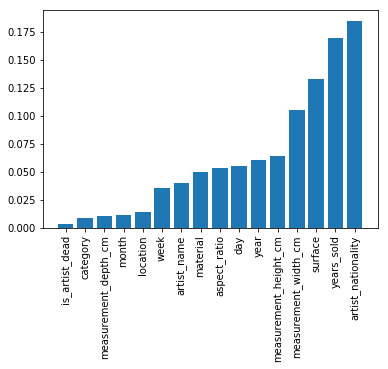

In [63]:
y_pred = cv_res_adaboost.best_estimator_.predict(test)
print("r2:",metrics.r2_score(y_test, y_pred))
print("Mean Absolute Error :",metrics.mean_absolute_error(y_test, y_pred))
print("Mean Sq Error :",metrics.mean_squared_error(y_test, y_pred))
importance = cv_res_adaboost.best_estimator_.feature_importances_
x = np.argsort(importance)[-20:]
plt.bar(range(0,len(x)),importance[x])
plt.xticks(range(0,len(x)),tuple(data.columns.values[x]),rotation='vertical')
plt.show()

In [37]:
print("r2:",metrics.r2_score(y_train, clf.predict(train)))
print("Mean Absolute Error :",metrics.mean_absolute_error(y_train, clf.predict(train)))
print("Mean Sq Error :",metrics.mean_squared_error(y_train, clf.predict(train)))

[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    1.3s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    3.0s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    5.3s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    6.6s finished


r2: 0.934398590958


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    1.2s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    2.8s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    5.0s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    6.4s finished


Mean Absolute Error : 29078.3925968


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    1.3s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    3.1s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    5.4s


Mean Sq Error : 21844665684.5


[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    6.8s finished


In [79]:
gb_grid_params = {
    'learning_rate': [0.1, 0.05, 0.02, 0.01],
    'max_depth': [4, 6, 8],
    'min_samples_leaf': [20, 50,100,150],
    'max_features': [1.0, 0.3, 0.1],
    'n_estimators':list(range(20,81,10))
}
clf = GradientBoostingRegressor()
res = benchmark(clf,train,y_train,test,y_test,gb_grid_params,np.array(train.columns),n_iter=30)


________________________________________________________________________________
Training: 
GradientBoostingRegressor
Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV] n_estimators=60, min_samples_leaf=20, max_features=0.3, max_depth=4, learning_rate=0.01 
[CV]  n_estimators=60, min_samples_leaf=20, max_features=0.3, max_depth=4, learning_rate=0.01, total=   3.4s
[CV] n_estimators=60, min_samples_leaf=20, max_features=0.3, max_depth=4, learning_rate=0.01 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.9s remaining:    0.0s


[CV]  n_estimators=60, min_samples_leaf=20, max_features=0.3, max_depth=4, learning_rate=0.01, total=   3.6s
[CV] n_estimators=60, min_samples_leaf=20, max_features=0.3, max_depth=4, learning_rate=0.01 
[CV]  n_estimators=60, min_samples_leaf=20, max_features=0.3, max_depth=4, learning_rate=0.01, total=   3.9s
[CV] n_estimators=60, min_samples_leaf=20, max_features=0.3, max_depth=4, learning_rate=0.01 
[CV]  n_estimators=60, min_samples_leaf=20, max_features=0.3, max_depth=4, learning_rate=0.01, total=   4.1s
[CV] n_estimators=60, min_samples_leaf=20, max_features=0.3, max_depth=4, learning_rate=0.01 
[CV]  n_estimators=60, min_samples_leaf=20, max_features=0.3, max_depth=4, learning_rate=0.01, total=   4.1s
[CV] n_estimators=70, min_samples_leaf=20, max_features=1.0, max_depth=8, learning_rate=0.02 
[CV]  n_estimators=70, min_samples_leaf=20, max_features=1.0, max_depth=8, learning_rate=0.02, total=  41.2s
[CV] n_estimators=70, min_samples_leaf=20, max_features=1.0, max_depth=8, learn

[CV]  n_estimators=20, min_samples_leaf=100, max_features=1.0, max_depth=8, learning_rate=0.01, total=   5.1s
[CV] n_estimators=20, min_samples_leaf=100, max_features=1.0, max_depth=8, learning_rate=0.01 
[CV]  n_estimators=20, min_samples_leaf=100, max_features=1.0, max_depth=8, learning_rate=0.01, total=   4.9s
[CV] n_estimators=20, min_samples_leaf=100, max_features=1.0, max_depth=8, learning_rate=0.01 
[CV]  n_estimators=20, min_samples_leaf=100, max_features=1.0, max_depth=8, learning_rate=0.01, total=   5.1s
[CV] n_estimators=80, min_samples_leaf=100, max_features=0.1, max_depth=4, learning_rate=0.1 
[CV]  n_estimators=80, min_samples_leaf=100, max_features=0.1, max_depth=4, learning_rate=0.1, total=   0.9s
[CV] n_estimators=80, min_samples_leaf=100, max_features=0.1, max_depth=4, learning_rate=0.1 
[CV]  n_estimators=80, min_samples_leaf=100, max_features=0.1, max_depth=4, learning_rate=0.1, total=   0.9s
[CV] n_estimators=80, min_samples_leaf=100, max_features=0.1, max_depth=4,

[CV]  n_estimators=70, min_samples_leaf=50, max_features=0.1, max_depth=8, learning_rate=0.05, total=   2.1s
[CV] n_estimators=70, min_samples_leaf=50, max_features=0.1, max_depth=8, learning_rate=0.05 
[CV]  n_estimators=70, min_samples_leaf=50, max_features=0.1, max_depth=8, learning_rate=0.05, total=   2.4s
[CV] n_estimators=80, min_samples_leaf=50, max_features=0.1, max_depth=8, learning_rate=0.1 
[CV]  n_estimators=80, min_samples_leaf=50, max_features=0.1, max_depth=8, learning_rate=0.1, total=   2.4s
[CV] n_estimators=80, min_samples_leaf=50, max_features=0.1, max_depth=8, learning_rate=0.1 
[CV]  n_estimators=80, min_samples_leaf=50, max_features=0.1, max_depth=8, learning_rate=0.1, total=   4.6s
[CV] n_estimators=80, min_samples_leaf=50, max_features=0.1, max_depth=8, learning_rate=0.1 
[CV]  n_estimators=80, min_samples_leaf=50, max_features=0.1, max_depth=8, learning_rate=0.1, total=   2.9s
[CV] n_estimators=80, min_samples_leaf=50, max_features=0.1, max_depth=8, learning_ra

[CV]  n_estimators=70, min_samples_leaf=20, max_features=0.1, max_depth=8, learning_rate=0.1, total=   4.7s
[CV] n_estimators=80, min_samples_leaf=20, max_features=0.3, max_depth=8, learning_rate=0.02 
[CV]  n_estimators=80, min_samples_leaf=20, max_features=0.3, max_depth=8, learning_rate=0.02, total=  15.4s
[CV] n_estimators=80, min_samples_leaf=20, max_features=0.3, max_depth=8, learning_rate=0.02 
[CV]  n_estimators=80, min_samples_leaf=20, max_features=0.3, max_depth=8, learning_rate=0.02, total=  16.0s
[CV] n_estimators=80, min_samples_leaf=20, max_features=0.3, max_depth=8, learning_rate=0.02 
[CV]  n_estimators=80, min_samples_leaf=20, max_features=0.3, max_depth=8, learning_rate=0.02, total=  15.8s
[CV] n_estimators=80, min_samples_leaf=20, max_features=0.3, max_depth=8, learning_rate=0.02 
[CV]  n_estimators=80, min_samples_leaf=20, max_features=0.3, max_depth=8, learning_rate=0.02, total=  16.2s
[CV] n_estimators=80, min_samples_leaf=20, max_features=0.3, max_depth=8, learni

[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed: 17.3min finished


train time: 1075.761s
r2: 0.274235037641
Mean Absolute Error : 111680.035275
Mean Sq Error : 512364947129.0
test time:  0.187s



,mean_fit_time,mean_score_time,mean_test_mse,mean_test_r2,mean_train_mse,mean_train_r2,param_learning_rate,param_max_depth,param_max_features,param_min_samples_leaf,...,split4_test_mse,split4_test_r2,split4_train_mse,split4_train_r2,std_fit_time,std_score_time,std_test_mse,std_test_r2,std_train_mse,std_train_r2
0,3.677182,0.133705,-3.092229e+11,0.074522,-3.037309e+11,0.087037,0.01,4,0.3,20,...,-2.889174e+11,0.084681,-3.105650e+11,0.079320,0.275039,0.006721,1.496828e+11,0.009902,3.373494e+10,0.008631
1,41.970156,0.201472,-2.583374e+11,0.231846,-2.278631e+11,0.315189,0.02,8,1,20,...,-2.359228e+11,0.252573,-2.300173e+11,0.318106,0.817238,0.004731,1.310998e+11,0.028790,2.583633e+10,0.008343
2,5.496951,0.127762,-2.715555e+11,0.197096,-2.555767e+11,0.232927,0.05,8,0.3,50,...,-2.510849e+11,0.204538,-2.586266e+11,0.233293,0.148698,0.003568,1.395634e+11,0.029904,3.121153e+10,0.007312
3,1.678362,0.135600,-3.001876e+11,0.107518,-2.961826e+11,0.110913,0.05,4,0.1,100,...,-2.830079e+11,0.103403,-3.012389e+11,0.106968,0.075116,0.010641,1.497048e+11,0.020035,3.590904e+10,0.004921
4,18.633569,0.155022,-2.873511e+11,0.147606,-2.799286e+11,0.160181,0.02,6,1,100,...,-2.707783e+11,0.142147,-2.831700e+11,0.160534,0.483051,0.003959,1.448758e+11,0.023719,3.511027e+10,0.008894
5,1.694261,0.099786,-3.048876e+11,0.093417,-3.018425e+11,0.093892,0.02,6,0.1,150,...,-2.863462e+11,0.092826,-3.052141e+11,0.095183,0.573617,0.016595,1.516520e+11,0.020113,3.647306e+10,0.004254
6,11.214104,0.084924,-2.255775e+11,0.329557,-1.824095e+11,0.450074,0.1,8,1,50,...,-1.966261e+11,0.377069,-1.833116e+11,0.456567,0.159613,0.002068,1.165510e+11,0.038107,1.641211e+10,0.018645
7,1.327337,0.038176,-3.022156e+11,0.100709,-2.983433e+11,0.104539,0.05,4,1,150,...,-2.856091e+11,0.095162,-3.024819e+11,0.103283,0.034647,0.001200,1.497293e+11,0.018485,3.639280e+10,0.005366
8,5.000411,0.050103,-3.174452e+11,0.052303,-3.150516e+11,0.054041,0.01,8,1,100,...,-3.001650e+11,0.049047,-3.193468e+11,0.053286,0.100703,0.002514,1.546592e+11,0.012793,3.758832e+10,0.002188
9,0.833160,0.072344,-2.874175e+11,0.147905,-2.788030e+11,0.162577,0.1,4,0.1,100,...,-2.663725e+11,0.156105,-2.814553e+11,0.165617,0.017589,0.002686,1.460553e+11,0.025273,3.257637e+10,0.005412
